# Project Title : Food101 Image Clasification using Vision Transformers
# Author : Omar Mahmoud Abdel Rahman
# Date : 29/8/2024


In [181]:
# import needed dependencies
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from pathlib import Path
import os
import pathlib
import matplotlib.pyplot as plt
import PIL
import numpy as np

from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

In [151]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

## Loading and preprocessing the data

- we are going to use ImageFolder dataloader so we need to arrange the data according to its form
- train_data/class_name/image_x.jpg
- test_data/class_names/image_y.jpg

In [152]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
train_data_path = Path(train_data_dir)
test_data_path = Path(test_data_dir)

In [153]:
# creating a function to extract the class names from the path directory and return both class names and a dictionary that maps classes to integers
def get_class_names(data_path):
    class_names = sorted(entry.name for entry in list(os.scandir(data_path)) if entry.is_dir())
    class_to_idx = {}
    for i in range(len(class_names)):
        class_to_idx[class_names[i]] = i
    return class_names, class_to_idx

def idx_to_class(class_to_idx):
    idx_to_class = dict((i, class_name) for class_name, i in class_to_idx.items())
    return idx_to_class

In [154]:
class_names, class_to_idx = get_class_names(train_data_path)

idx_to_class_dict = idx_to_class(class_to_idx)

idx_to_class_dict

{0: 'pizza', 1: 'steak', 2: 'sushi'}

## In Order to use custom dataset specifically ImageFolder so you need to 
- 1- subclass the `torch.data.Dataset`class
- 2- overwrite the `__len__()` method
- 3- overwrite the `__getitem__()` method 

In [155]:
class CustomImageFolder(torch.utils.data.Dataset):
    
    def __init__(self,
                 data_path : pathlib.Path,
                 transform : torchvision.transforms = None):
        
        self.class_names,self.class_to_idx = get_class_names(data_path)
        
        self.transform = transform

        self.data_path = data_path

        self.data_pathes_list = list(data_path.glob('*/*.jpg'))
    
    def get_image_and_label(self, idx):
        image_path = self.data_pathes_list[idx]

        image = PIL.Image.open(image_path)

        class_name = image_path.parts[-2]

        class_idx = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)
        return image, class_idx
    
    def __len__(self):
        return len(self.data_pathes_list)
    
    def __getitem__(self, idx):

        image, image_label = self.get_image_and_label(idx)

        return image, image_label

In [156]:
train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

In [157]:
train_dataset = CustomImageFolder(train_data_path,
                                  transform= train_transform)

test_dataset = CustomImageFolder(test_data_path,
                                 transform = test_transform)

In [158]:
image, label = train_dataset[0]

In [159]:
image.shape

torch.Size([3, 224, 224])

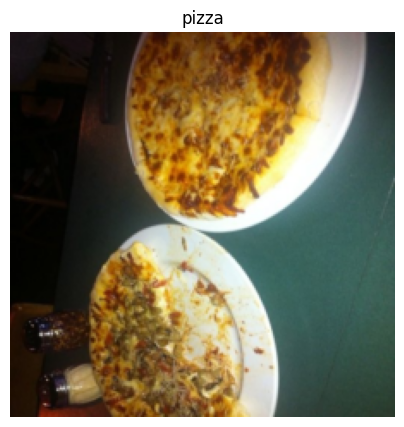

In [160]:
# plot an image to see weither our data loaded correctly
plt.figure(figsize=(5,5))
plt.imshow(image.permute([2, 1, 0]))
plt.axis(False);
plt.title(idx_to_class_dict[label])
plt.show();

# After we have successfully loaded the data we now want to turn it into dataloaders, so let's turn it into dataloader


In [161]:
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = 32,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = 32)

In [162]:
batch_data, batch_labels = next(iter(train_dataloader))

In [163]:
batch_data.shape, batch_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## After we've created our dataloader we want to build our Vision transformer

- for a vision transformer we first need to crop our input images into patches in our case we are dealing with 64x64 images 
- we then need to flatten each one of them
- after that we need to add positional embedding
- we need then to build our vision transformer main blocks 
- we finally we need to concatenate all of the blocks into one block
- train and test our model

#

In [164]:
# broke the whole model into smaller models and then concatenate all of them into one large module 
class PatchEmbedding(nn.Module):
    """Turn a 2D input image into a 1D sequence learnable embedding vector

    Args:
        in_channels (int) : Number of input channels for the input images: Default is 3.
        patch_size (int) : size of the cropped images "patches": Default to 16 as the Original Paper
        embedding_size : Size of Linear project "i.e The output size which will be converted into after applying linear projection : Default to 768 -> 16x16x3
    returns : 
        a flattened 1D vector that goes to the PositionEmbedding Module 
    """
    def __init__(self,
                 in_channels : int= 3,
                 kernel_size : int = 16,
                 emb_size : int = 768):
        super().__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.emb_size = emb_size

        self.Patcher = nn.Conv2d(in_channels=self.in_channels,
                                 out_channels = self.emb_size,
                                 kernel_size = self.kernel_size,
                                 stride = self.kernel_size,
                                 padding = 0)

        self.flatten = nn.Flatten(2, 3)
        
    def forward(self, x : torch.Tensor) -> torch.Tensor: 
        x = self.Patcher(x)
        # print(f"Shape after forward path : {x.shape}")
        x = self.flatten(x)
        # print(f"shape after flattening : {x.shape}")
        x = x.permute([0, 2, 1])
        # print(f"Final output shape : {x.shape}")
        return x 



In [165]:
simple_patcher = PatchEmbedding()

In [166]:
x = torch.randn((3, 224, 224))

x = simple_patcher(x.unsqueeze(0))

In [167]:
# lets test that PatchEmbedding On a whole batch data
patched_train_data_batch = simple_patcher(batch_data)

In [168]:
def add_class_token(patch_embedding_output : torch.Tensor = None,
                    emb_size : int = 768,
                    batch_size : int = 32):

    class_token = nn.Parameter(torch.randn(size = (batch_size, 1, emb_size)),
                               requires_grad = True)
    
    patch_embedding_with_class_token = torch.cat([class_token , patch_embedding_output],
                                                 dim = 1)
    return patch_embedding_with_class_token

In [169]:
# Testing that our class_token is correctlly concatenated
patch_embedding_with_class_token = add_class_token(patched_train_data_batch)

print(f"shape of the batches before class token is : {patched_train_data_batch.shape}")

print(f"shape of the batches after concatenating the class token on top of each batch : {patch_embedding_with_class_token.shape}")

shape of the batches before class token is : torch.Size([32, 196, 768])
shape of the batches after concatenating the class token on top of each batch : torch.Size([32, 197, 768])


In [170]:
# Adding the position embedding on the patches embeddings
def add_position_embedding(patch_embedding_with_class_token : torch.Tensor = None,
                           emb_size : int = 768):
    
    num_of_patches = patch_embedding_with_class_token.shape[1]
    
    positional_embedding = nn.Parameter(torch.randn(size = (1, num_of_patches, emb_size)), requires_grad= True)
    print(positional_embedding.shape)
    full_transformer_input = patch_embedding_with_class_token + positional_embedding
    print(f"shape of the data with out positional embedding : {patch_embedding_with_class_token.shape}")
    print(f"shape of the data after adding the positional emeddings : {full_transformer_input.shape}")
    return full_transformer_input


In [171]:
full_transformer_input = add_position_embedding(patch_embedding_with_class_token)

torch.Size([1, 197, 768])
shape of the data with out positional embedding : torch.Size([32, 197, 768])
shape of the data after adding the positional emeddings : torch.Size([32, 197, 768])


In [172]:
class MultiHeadAttention(nn.Module):
    """Creates Multi Head Self Attention module"""

    def __init__(self,
                 embedded_dim : int = 768,
                 num_heads : int =  12,
                 attn_drop_out : float = 0.2):
        super().__init__()

        self.layer_norm = nn.LayerNorm(embedded_dim)

        self.multi_head_attn = nn.MultiheadAttention(embedded_dim,
                                                     num_heads,
                                                     dropout= attn_drop_out,
                                                     batch_first= True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multi_head_attn(query = x,
                                              key = x,
                                              value = x,
                                              need_weights = False)
        return attn_output

In [173]:
class MLPBlock(nn.Module):

    def __init__(self,
                 emb_dim : int = 768,
                 mlp_out : int = 3072, # such as the original Paper for Vit base
                 drop_out : float = 0.1): 
        super().__init__()

        self.layer_norm = nn.LayerNorm(emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features= emb_dim,
                      out_features = mlp_out),
            nn.GELU(),
            nn.Dropout(drop_out),
            nn.Linear(in_features = mlp_out,
                      out_features = emb_dim),
            nn.GELU(),
            nn.Dropout(drop_out)
        )
    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        # print(x.shape)
        x = self.mlp(x)
        # print(f"out shape of the transformer : {x.shape}")
        return x
    

In [174]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 emb_size : int = 768,
                 num_heads : int = 12,
                 mlp_out : float = 3072,
                 mlp_drop_out :float = 0.1,
                 attn_drop_out : float = 0.1):
        
        super().__init__()

        self.msa_block = MultiHeadAttention(emb_size,
                                            num_heads,
                                            attn_drop_out)
        
        self.mlp_block = MLPBlock(emb_dim = emb_size,
                                  mlp_out = mlp_out,
                                  drop_out = mlp_drop_out)

    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.msa_block(x) + x 

        x = self.mlp_block(x) + x

        return x
        

In [175]:
from torchinfo import summary
BATCH_SIZE = 32
PATCH_SIZE = 197
EMBEDDING_DIMENSION = 768

transformer_encoder = TransformerEncoder()
summary(transformer_encoder,
        input_size = (BATCH_SIZE, PATCH_SIZE, EMBEDDING_DIMENSION),
        col_names=['input_size', 'output_size', 'num_params','trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoder (TransformerEncoder)            [32, 197, 768]            [32, 197, 768]            --                        True
├─MultiHeadAttention (msa_block)                   [32, 197, 768]            [32, 197, 768]            --                        True
│    └─LayerNorm (layer_norm)                      [32, 197, 768]            [32, 197, 768]            1,536                     True
│    └─MultiheadAttention (multi_head_attn)        --                        [32, 197, 768]            2,362,368                 True
├─MLPBlock (mlp_block)                             [32, 197, 768]            [32, 197, 768]            --                        True
│    └─LayerNorm (layer_norm)                      [32, 197, 768]            [32, 197, 768]            1,536                     True
│    └─Sequential (mlp)                            [32, 1

In [176]:
# Finally we need to make the classifier with number of classes equal to the data number of classes
class Vit(nn.Module):

    def __init__(self,
                 img_size : int = 224,
                 embedding_dropout : float = 0.1,
                 patch_size : int = 16,
                 emb_size : int  = 768,
                 in_channels : int = 3,
                 num_head : int = 12,
                 mlp_out : int = 3072,
                 mlp_dropout : float = 0.1,
                 drop_out : float = 0.1,
                 attn_dropout :float = 0.1,
                 num_classes : int = 3,
                 num_transformer_layer :int = 4):

        super().__init__()
        
        self.num_patches =  (img_size * img_size) // (patch_size ** 2)

        self.class_embeddings = nn.Parameter(torch.randn(size = (1, 1, emb_size)),
                                             requires_grad = True)
        
        self.position_embeddings = nn.Parameter(torch.randn(1, self.num_patches + 1, emb_size),
                                                requires_grad = True)
        
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                              kernel_size = patch_size,
                                              emb_size  = emb_size)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(emb_size = emb_size,
                                                                      num_heads = num_head,
                                                                      mlp_out  = mlp_out,
                                                                      mlp_drop_out = mlp_dropout,
                                                                      attn_drop_out = attn_dropout) for _ in range(num_transformer_layer)])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(in_features= emb_size,
                      out_features = num_classes),
        )

    def forward(self, x :torch.Tensor)->torch.Tensor:

        batch_size = x.shape[0]

        class_token = self.class_embeddings.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)

        x = torch.cat([class_token, x], dim = 1)

        x = self.position_embeddings + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x


In [177]:
vit = Vit(num_classes= len(class_names))

In [178]:
#choosing loss and optimzer 

loss_fnc = nn.CrossEntropyLoss()
optimzer = torch.optim.Adam(params = vit.parameters(),
                           lr = 0.01)


# accuracy function
def accuracy_fn(y_pred, y_true):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Create train and test loop functions

#setting device agnostic code 
# device = 'cpu'

def train_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fnc : torch.nn.Module,
               optimzer : torch.optim.Optimizer,
               acc_fnc,
               device : torch.device = device):
    """Performce a training step on the dataloader"""
    train_loss = 0
    train_acc = 0
    model.to(device)
    model.train()
    for X, y in data_loader:
        # send the data to the target device        
        X, y = X.to(device), y.to(device)
        # Do forward path
        y_preds = model(X)
        #calculate the training loss
        loss = loss_fnc(y_preds, y)
        train_loss += loss.item()
        #optimzer zero grad
        optimzer.zero_grad()
        # loss backward
        train_acc += acc_fnc(y_preds.argmax(dim = 1), y)
        #Loss backward
        loss.backward()
        #optimzer step
        optimzer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    #return train loss and train acc
    return train_loss, train_acc


def test_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fnc : torch.nn.Module,
               acc_fnc,
               device : torch.device = device):
    """Performce a testing step on the dataloader"""

    model.to(device)
    test_loss = 0
    test_acc = 0
    model.eval()
    for X, y in data_loader:
        
        # Sending the data to target device
        X, y = X.to(device), y.to(device)

        #Forward path
        with torch.inference_mode():
            y_preds = model(X)
        
        # Calculate the loss
        loss = loss_fnc(y_preds, y)
        test_loss += loss.item()

        # Calculate test accuracy
        test_acc += acc_fnc(y_preds.argmax(dim = 1), y)
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    return test_loss, test_acc
    
def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model: torch.nn.Module,
          train_data_loader:torch.utils.data.DataLoader,
          test_data_loader : torch.utils.data.DataLoader,
          optimzer : torch.optim.Optimizer,
          loss_fnc : torch.nn.Module,
          acc_fnc,
          calculate_train_time : bool = True,
          seed : int = None,
          device : torch.device = device,
          epochs : int = 10,
          early_stop : bool = False,
          patience : int = 1,
          min_delta : int = 0):
    
    if early_stop:
        early_stopper = EarlyStopper(patience=patience,
                                     min_delta = min_delta)
    else :
        early_stopper = None


    if calculate_train_time:
        train_time_start = timer()
    

    if seed : 
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

    results = {"train_loss_epoch" : [],
               "train_acc_epoch" : [],
               "test_loss_epoch" : [],
               "test_acc_epoch" : [],
               "Estimated_train_time" : None
               }
    
    

    model.to(device)
    for epoch in tqdm(range(epochs)):

        #printing epoch number
        print(f"Epoch: {epoch}\n --------")

        # One training step per epoch
        train_loss, train_acc = train_step(model = model,
                   data_loader= train_data_loader,
                   loss_fnc=loss_fnc,
                   optimzer = optimzer,
                   acc_fnc = acc_fnc,
                   device = device)
        results['train_loss_epoch'].append(train_loss), results['train_acc_epoch'].append(train_acc)
        # One testing step per epoch

        test_loss , test_acc = test_step(model = model,
                  data_loader = test_data_loader,
                  loss_fnc = loss_fnc,
                  acc_fnc = acc_fnc,
                  device = device)
        
        results['test_loss_epoch'].append(test_loss), results['test_acc_epoch'].append(test_acc)
        #print what is happening 
        print(f"Train Loss : {train_loss:.4f} | Train Accuravy : {train_acc:.2f}")
        print(f"Test Loss : {test_loss:.4f} | Test Accuracy : {test_acc:.2f}")

        #early stopping
        if early_stopper.early_stop(test_loss):
            print(f"we are in epoch {epoch}")
            break
    
    train_time_end = timer()


    if calculate_train_time:
        results['Estimated_train_time'] = print_train_time(start = train_time_start, end = train_time_end)
        print_train_time(start = train_time_start, end = train_time_end)
    return results

In [179]:
results = train(vit,
      train_dataloader,
      test_dataloader,
      optimzer,
      loss_fnc,
      accuracy_fn,
      seed = 42,
      device = device,
      epochs = 10,
      early_stop=True,
      patience = 3,
      min_delta = 0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
 --------
Train Loss : 3.7897 | Train Accuravy : 33.54
Test Loss : 2.1248 | Test Accuracy : 36.25
Epoch: 1
 --------
Train Loss : 1.5740 | Train Accuravy : 30.62
Test Loss : 1.9422 | Test Accuracy : 35.00
Epoch: 2
 --------
Train Loss : 1.4076 | Train Accuravy : 30.83
Test Loss : 1.1849 | Test Accuracy : 36.25
Epoch: 3
 --------
Train Loss : 1.2393 | Train Accuravy : 29.79
Test Loss : 1.1060 | Test Accuracy : 35.62
Epoch: 4
 --------
Train Loss : 1.1352 | Train Accuravy : 37.08
Test Loss : 1.2211 | Test Accuracy : 35.00
Epoch: 5
 --------
Train Loss : 1.2097 | Train Accuravy : 35.62
Test Loss : 1.2541 | Test Accuracy : 29.38
Epoch: 6
 --------
Train Loss : 1.2157 | Train Accuravy : 36.88
Test Loss : 1.2121 | Test Accuracy : 36.25
Epoch: 7
 --------
Train Loss : 1.2038 | Train Accuravy : 29.79
Test Loss : 1.2338 | Test Accuracy : 35.00
Epoch: 8
 --------
Train Loss : 1.1395 | Train Accuravy : 36.46
Test Loss : 1.6973 | Test Accuracy : 28.75
Epoch: 9
 --------
Train Loss : 1.296

In [182]:
def plot_loss_curves(epochs : int,
                     train_loss : np.array,
                     test_loss : np.array,
                     train_acc : np.array,
                     test_acc : np.array):
    """Function used to plot the train and test losses and accuracies through epochs"""
    plt.figure(figsize = (10,6))
    epochs = np.array(range(epochs))
    # Plotting the train and test lossed 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = 'train loss')
    plt.plot(epochs, test_loss, label = 'test loss')
    plt.axis(True)
    plt.title(f"Train and Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Train Test Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label = 'train acc')
    plt.plot(epochs, test_acc, label = 'test acc')
    plt.axis(True);
    plt.xlabel("Epochs")
    plt.ylabel("Train Test Accuracy")
    plt.title(f"Train and Test Accuracy Curves")
    plt.legend()
    plt.show();

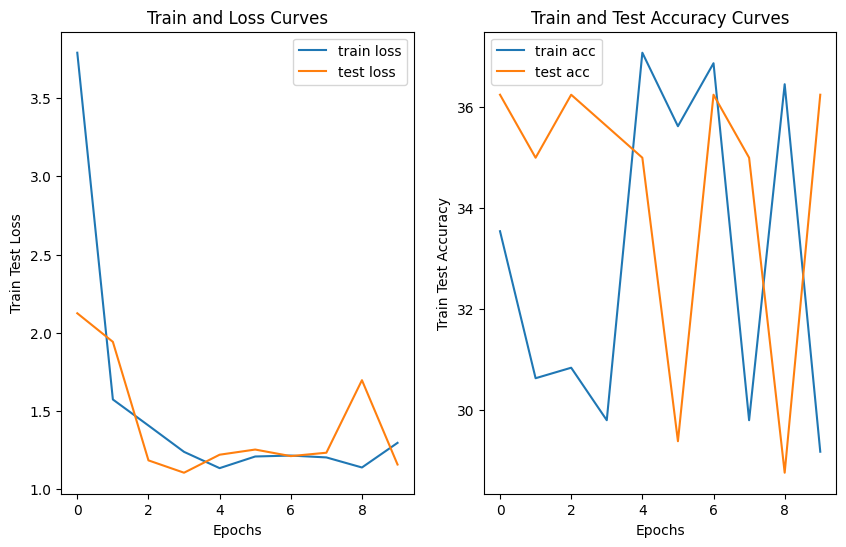

In [183]:
train_loss, test_loss = np.array(results['train_loss_epoch']), np.array(results['test_loss_epoch'])
train_acc , test_acc  = np.array(results['train_acc_epoch']), np.array(results['test_acc_epoch'])
epochs = len(train_loss)
plot_loss_curves(epochs, train_loss, test_loss, train_acc, test_acc)   

In [184]:
# Pipeline for infernce Mode "Predicting on custome images"

def Predict_Custom_Images(model:torch.nn.Module,
                          image_path : str,
                          device : torch.device = None):
    
    """Function taking image path as a string and a model and returns model_prediction and confedence level"""
    transform = transforms.Compose([
        transforms.Resize(size = (224, 224), antialias=True),
        # transforms.ToTensor()
    ])
    
    # reading an image using its path
    img = torchvision.io.read_image(image_path).type(torch.float32) / 255
    # Transforming our image into the right requirnments for our model
    img = transform(img)
 
    # try :
    #     model.to(device)
    # except :
    #     print(f"you are not specifing and device and you are now working on the cpu")
    #     model.to('cpu')
 
 
    # Making our model into the inference_mode so our grades does not change
    model.eval()
    with torch.inference_mode():
        # Calculating the raw logits 
        raw_logits = model(img.unsqueeze(0))

    # Converting the raw logits into prediction probabilities and then into prediction labels
    prediction_probability = torch.softmax(raw_logits, dim = 1).max().item()
    prediction_label = torch.softmax(raw_logits, dim = 1).argmax(dim = 1).item()

    print(f"prediction label : {class_names[prediction_label]}\nConfidence : {(prediction_probability * 100):.2f}%")
    return prediction_label, prediction_probability

In [186]:
image_path = './Data/train/sushi/17704.jpg'
prediction_label, prediction_probabilty = Predict_Custom_Images(model = vit,
                                         image_path = image_path)

prediction label : steak
Confidence : 52.40%


In [187]:
from pathlib import Path
# creating the model directory 

Model_path = Path("models")
Model_path.mkdir(parents=True, exist_ok= True)
# create model save path 
MODEL_NAME = "Vision_Transformer_from_scratch.pth"
MODEL_SAVE_PATH = Model_path / MODEL_NAME
# saving model 
print(f"saving model to : {MODEL_SAVE_PATH} ")
torch.save(vit.state_dict(), MODEL_SAVE_PATH)

saving model to : models\Vision_Transformer_from_scratch.pth 
